# Precision loss due to float32 conversion with ONNX

The notebook studies the loss of precision while converting a non-continuous model into float32. It studies the conversion of [GradientBoostingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html) and then a [DecisionTreeRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html) for which a runtime supported float64 was implemented.

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
%matplotlib inline

## GradientBoostingClassifier

We just train such a model on Iris dataset.

In [3]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier

In [4]:
iris = load_iris()
X, y = iris.data, iris.target
X_train, X_test, y_train, _ = train_test_split(
    X, y, random_state=1, shuffle=True)
clr = GradientBoostingClassifier(n_estimators=20)
clr.fit(X_train, y_train)

GradientBoostingClassifier(n_estimators=20)

We are interested into the probability of the last class.

In [5]:
exp = clr.predict_proba(X_test)[:, 2]
exp

array([0.03010582, 0.03267555, 0.03267424, 0.03010582, 0.94383517,
       0.02866979, 0.94572751, 0.03010582, 0.03010582, 0.94383517,
       0.03267555, 0.03010582, 0.94696795, 0.0317053 , 0.03267555,
       0.03010582, 0.03267555, 0.03267555, 0.03010582, 0.03010582,
       0.03267555, 0.03267555, 0.94577389, 0.03010582, 0.91161635,
       0.03267555, 0.03010582, 0.03010582, 0.03267424, 0.94282974,
       0.03267424, 0.94696795, 0.03267555, 0.94696795, 0.9387834 ,
       0.03010582, 0.03267555, 0.03010582])

## Conversion to ONNX and comparison to original outputs

In [6]:
import numpy
from mlprodict.onnxrt import OnnxInference
from mlprodict.onnx_conv import to_onnx

In [7]:
model_def = to_onnx(clr, X_train.astype(numpy.float32))
oinf = OnnxInference(model_def)
inputs = {'X': X_test.astype(numpy.float32)}
outputs = oinf.run(inputs)
outputs

{'output_label': array([0, 1, 1, 0, 2, 1, 2, 0, 0, 2, 1, 0, 2, 1, 1, 0, 1, 1, 0, 0, 1, 1,
        2, 0, 2, 1, 0, 0, 1, 2, 1, 2, 1, 2, 2, 0, 1, 0], dtype=int64),
 'output_probability': [{0: 0.94445217, 1: 0.025442092, 2: 0.030105816},
  {0: 0.02932842, 1: 0.9379961, 2: 0.032675553},
  {0: 0.029367255, 1: 0.93795854, 2: 0.032674246},
  {0: 0.94445217, 1: 0.025442092, 2: 0.030105816},
  {0: 0.026494453, 1: 0.02967037, 2: 0.9438352},
  {0: 0.027988827, 1: 0.94334143, 2: 0.028669795},
  {0: 0.026551371, 1: 0.027721122, 2: 0.9457275},
  {0: 0.94445217, 1: 0.025442092, 2: 0.030105816},
  {0: 0.94445217, 1: 0.025442092, 2: 0.030105816},
  {0: 0.026494453, 1: 0.02967037, 2: 0.9438352},
  {0: 0.02932842, 1: 0.9379961, 2: 0.032675553},
  {0: 0.94445217, 1: 0.025442092, 2: 0.030105816},
  {0: 0.026586197, 1: 0.026445853, 2: 0.946968},
  {0: 0.027929045, 1: 0.9403657, 2: 0.0317053},
  {0: 0.02932842, 1: 0.9379961, 2: 0.032675553},
  {0: 0.94445217, 1: 0.025442092, 2: 0.030105816},
  {0: 0.02932842,

Let's extract the probability of the last class.

In [8]:
def output_fct(res):
    val = res['output_probability'].values
    return val[:, 2]

output_fct(outputs)

array([0.03010582, 0.03267555, 0.03267425, 0.03010582, 0.9438352 ,
       0.0286698 , 0.9457275 , 0.03010582, 0.03010582, 0.9438352 ,
       0.03267555, 0.03010582, 0.946968  , 0.0317053 , 0.03267555,
       0.03010582, 0.03267555, 0.03267555, 0.03010582, 0.03010582,
       0.03267555, 0.03267555, 0.9457739 , 0.03010582, 0.9116163 ,
       0.03267555, 0.03010582, 0.03010582, 0.03267425, 0.9428297 ,
       0.03267425, 0.946968  , 0.03267555, 0.946968  , 0.9387834 ,
       0.03010582, 0.03267555, 0.03010582], dtype=float32)

Let's compare both predictions.

In [9]:
diff = numpy.sort(numpy.abs(output_fct(outputs) - exp))
diff

array([1.35649712e-09, 1.35649712e-09, 1.35649712e-09, 1.35649712e-09,
       1.35649712e-09, 1.35649712e-09, 1.35649712e-09, 1.35649712e-09,
       1.35649712e-09, 1.35649712e-09, 1.40241483e-09, 1.40403427e-09,
       1.40403427e-09, 1.40403427e-09, 4.08553857e-09, 7.87733068e-09,
       8.05985446e-09, 8.05985446e-09, 8.05985446e-09, 8.05985446e-09,
       8.05985446e-09, 8.05985446e-09, 8.05985446e-09, 8.05985446e-09,
       8.05985446e-09, 8.05985446e-09, 8.05985446e-09, 8.05985446e-09,
       8.05985446e-09, 9.19990018e-09, 9.34906490e-09, 1.80944041e-08,
       2.73915506e-08, 2.81494498e-08, 2.81494498e-08, 6.50696940e-08,
       6.50696940e-08, 6.50696940e-08])

The highest difference is quite high but there is only one.

In [10]:
max(diff)

6.506969396635753e-08

## Why this difference?

The function *astype_range* returns floats (single floats) around the true value of the orginal features in double floats. 

In [11]:
from mlprodict.onnx_tools.model_checker import astype_range
astype_range(X_test[:5])

(array([[5.7999997 , 3.9999995 , 1.1999999 , 0.19999999],
        [5.0999994 , 2.4999998 , 2.9999998 , 1.0999999 ],
        [6.5999994 , 2.9999998 , 4.3999996 , 1.3999999 ],
        [5.3999996 , 3.8999996 , 1.2999998 , 0.39999998],
        [7.899999  , 3.7999995 , 6.3999996 , 1.9999998 ]], dtype=float32),
 array([[5.8000007 , 4.0000005 , 1.2000002 , 0.20000002],
        [5.1000004 , 2.5000002 , 3.0000002 , 1.1000001 ],
        [6.6000004 , 3.0000002 , 4.4000006 , 1.4000001 ],
        [5.4000006 , 3.9000006 , 1.3000001 , 0.40000004],
        [7.900001  , 3.8000004 , 6.4000006 , 2.0000002 ]], dtype=float32))

If a decision tree uses a threshold which verifies ``float32(t) != t``, it cannot be converted into single float without discrepencies. The interval ``[float32(t - |t|*1e-7), float32(t + |t|*1e-7)]`` is close to all double values converted to the same *float32* but every feature *x* in this interval verifies ``float32(x) >= float32(t)``. It is not an issue for continuous machine learned models as all errors usually compensate. For non continuous models, there might some outliers. Next function considers all intervals of input features and randomly chooses one extremity for each of them.

In [12]:
from mlprodict.onnx_tools.model_checker import onnx_shaker

In [13]:
n = 100
shaked = onnx_shaker(oinf, inputs, dtype=numpy.float32, n=n,
                     output_fct=output_fct)
shaked.shape

(38, 100)

The function draws out 100 input vectors randomly choosing one extremity for each feature. It then sort every row. First column is the lower bound, last column is the upper bound.

In [14]:
diff2 = shaked[:, n-1] - shaked[:, 0]
diff2

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.02333647, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        ], dtype=float32)

In [15]:
max(diff2)

0.02333647

We get the same value as before. At least one feature of one observation is really close to one threshold and changes the prediction.

## Bigger datasets

In [16]:
from sklearn.datasets import load_breast_cancer

data = load_breast_cancer()
X, y = data.data, data.target
X_train, X_test, y_train, _ = train_test_split(
    X, y, random_state=1, shuffle=True)
clr = GradientBoostingClassifier()
clr.fit(X_train, y_train)

GradientBoostingClassifier()

In [17]:
model_def = to_onnx(clr, X_train.astype(numpy.float32))
oinf = OnnxInference(model_def)
inputs = {'X': X_test.astype(numpy.float32)}

In [18]:
def output_fct1(res):
    val = res['output_probability'].values
    return val[:, 1]

n = 100
shaked = onnx_shaker(oinf, inputs, dtype=numpy.float32, n=n,
                     output_fct=output_fct1, force=1)
shaked.shape

(143, 100)

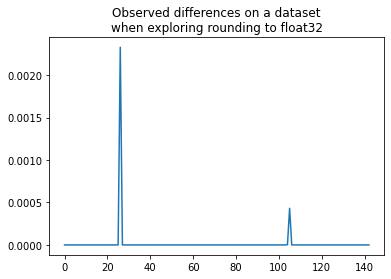

In [19]:
import matplotlib.pyplot as plt
plt.plot(shaked[:, n-1] - shaked[:, 0])
plt.title("Observed differences on a dataset\nwhen exploring rounding to float32");

## DecisionTreeRegressor

This model is much simple than the previous one as it contains only one tree.

In [20]:
from sklearn.datasets import load_diabetes
data = load_diabetes()
X, y = data.data, data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=2, random_state=2)

In [21]:
from sklearn.tree import DecisionTreeRegressor
clr = DecisionTreeRegressor()
clr.fit(X_train, y_train)

DecisionTreeRegressor()

In [22]:
ypred = clr.predict(X_test)

In [23]:
model_onnx = to_onnx(clr, X_train.astype(numpy.float32))

In [24]:
oinf = OnnxInference(model_onnx)
opred = oinf.run({'X': X_test.astype(numpy.float32)})['variable']

In [25]:
numpy.sort(numpy.abs(ypred - opred))[-5:]

array([1.52587891e-06, 1.52587891e-06, 1.52587891e-06, 1.52587891e-06,
       1.52587891e-06])

In [26]:
numpy.max(numpy.abs(ypred - opred) / ypred) * 100

4.680610146230323e-06

In [27]:
print("highest relative error: {0:1.3}%".format((numpy.max(numpy.abs(ypred - opred) / ypred) * 100)))

highest relative error: 4.68e-06%


The last difference is quite big. Let's reuse function *onnx_shaker*.

In [28]:
def output_fct_reg(res):
    val = res['variable']
    return val

n = 1000
shaked = onnx_shaker(oinf, {'X': X_test.astype(numpy.float32)},
                     dtype=numpy.float32, n=n,
                     output_fct=output_fct_reg, force=1)
shaked.shape

(127, 1000)

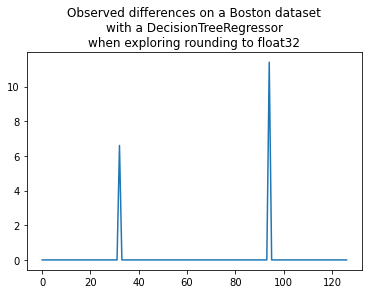

In [29]:
plt.plot(shaked[:, n-1] - shaked[:, 0])
plt.title("Observed differences on a Boston dataset\nwith a DecisionTreeRegressor"
          "\nwhen exploring rounding to float32");

That's consistent. This function is way to retrieve the error due to the conversion into float32 without using the expected values.

## Runtime supporting float64 for DecisionTreeRegressor

We prooved that the conversion to float32 introduces discrepencies in a statistical way. But if the runtime supports float64 and not only float32, we should have absolutely no discrepencies. Let's verify that error disappear when the  runtime supports an operator handling float64, which is the case for the python runtime for *DecisionTreeRegression*.

In [30]:
model_onnx64 = to_onnx(clr, X_train, rewrite_ops=True)

The option **rewrite_ops** is needed to tell the function the operator we need is not (yet) supported by the official specification of ONNX. [TreeEnsembleRegressor](https://github.com/onnx/onnx/blob/master/docs/Operators-ml.md#ai.onnx.ml.TreeEnsembleRegressor) only allows float coefficients and we need double coefficients. That's why the function rewrites the converter of this operator and selects the appropriate runtime operator **RuntimeTreeEnsembleRegressorDouble**. It works as if the ONNX specification was extended to support operator *TreeEnsembleRegressorDouble* which behaves the same but with double.

In [31]:
oinf64 = OnnxInference(model_onnx64)
opred64 = oinf64.run({'X': X_test})['variable']

The runtime operator is accessible with the following path:

In [32]:
oinf64.sequence_[0].ops_

Different from this one:

In [33]:
oinf.sequence_[0].ops_

And the highest absolute difference is now null.

In [34]:
numpy.max(numpy.abs(ypred - opred64))

0.0

## Interpretation

We may wonder if we should extend the ONNX specifications to support double for every operator. However, the fact the model predict a very different value for an observation indicates the prediction cannot be trusted as a very small modification of the input introduces a huge change on the output. I would use a different model. We may also wonder which prediction is the best one compare to the expected value...

In [35]:
i = numpy.argmax(numpy.abs(ypred - opred))
i

26

In [36]:
y_test[i], ypred[i], opred[i], opred64[i]

(50.0, 43.1, 43.1, 43.1)

Well at the end, it is only luck on that kind of example.